In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_regression, SelectKBest

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ProjectSize            541 non-null    int64 
 1   NumberOfWorkers        541 non-null    int64 
 2   ClimateCondition       541 non-null    object
 3   ProjectComplexity      541 non-null    int64 
 4   FundingType            541 non-null    object
 5   CompanyExperience      541 non-null    int64 
 6   EquipmentRating        541 non-null    int64 
 7   SupplyChainEfficiency  541 non-null    int64 
 8   TimeToComplete         541 non-null    int64 
dtypes: int64(7), object(2)
memory usage: 38.2+ KB
None
   ProjectSize  NumberOfWorkers ClimateCondition  ProjectComplexity  \
0         3100               11         Wet_Cold                  2   
1         3000               48         Wet_Cold                  6   
2         2700               60        Temperate                  

<ipython-input-2-d92ce4035c65>:15: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm')


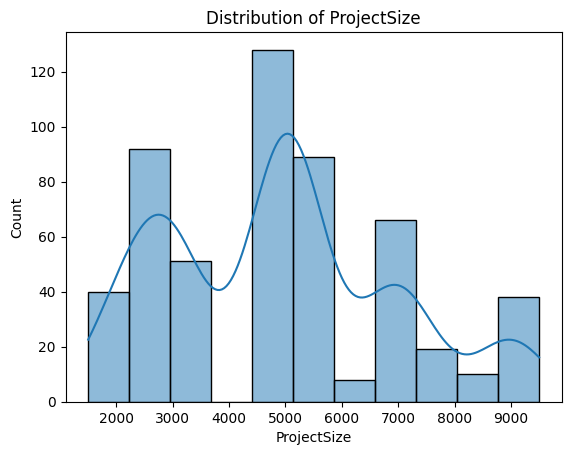

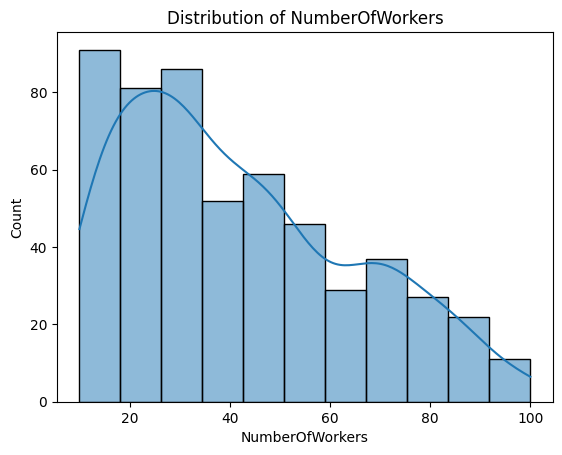

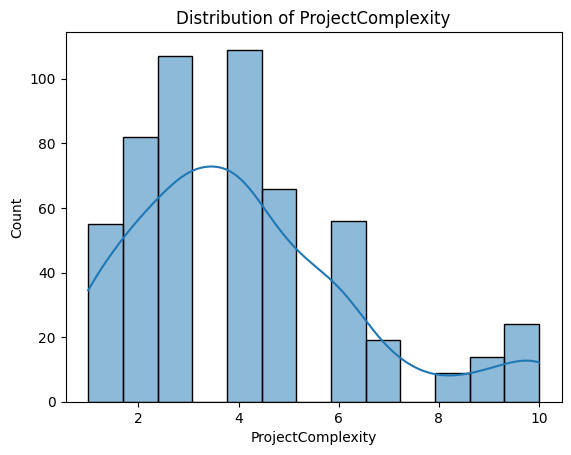

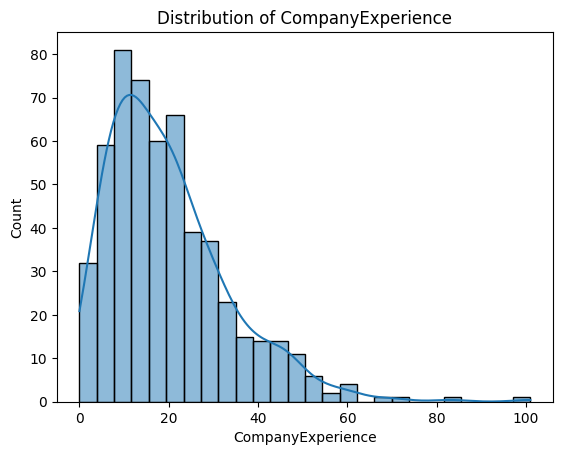

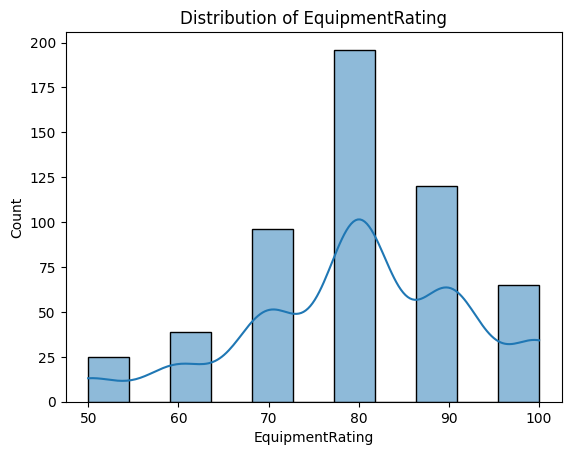

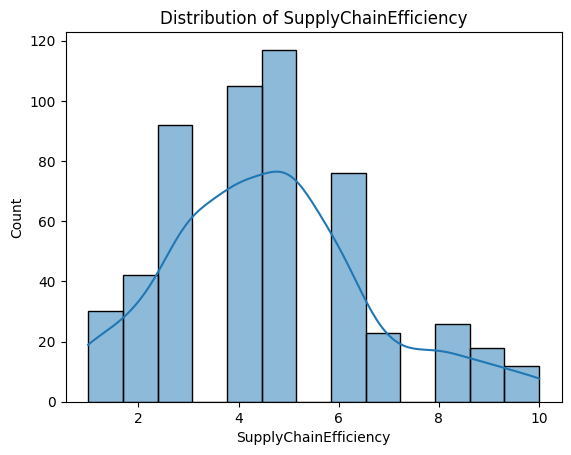

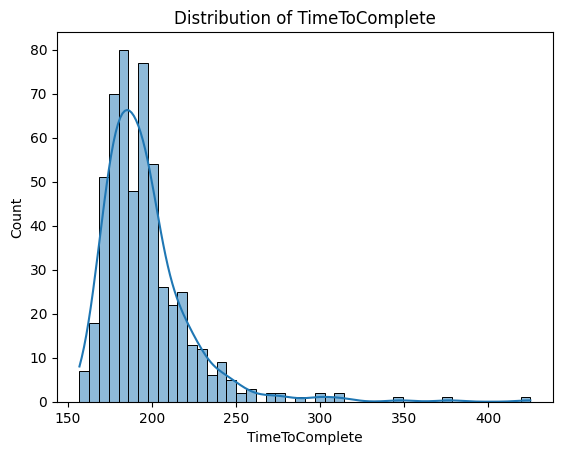

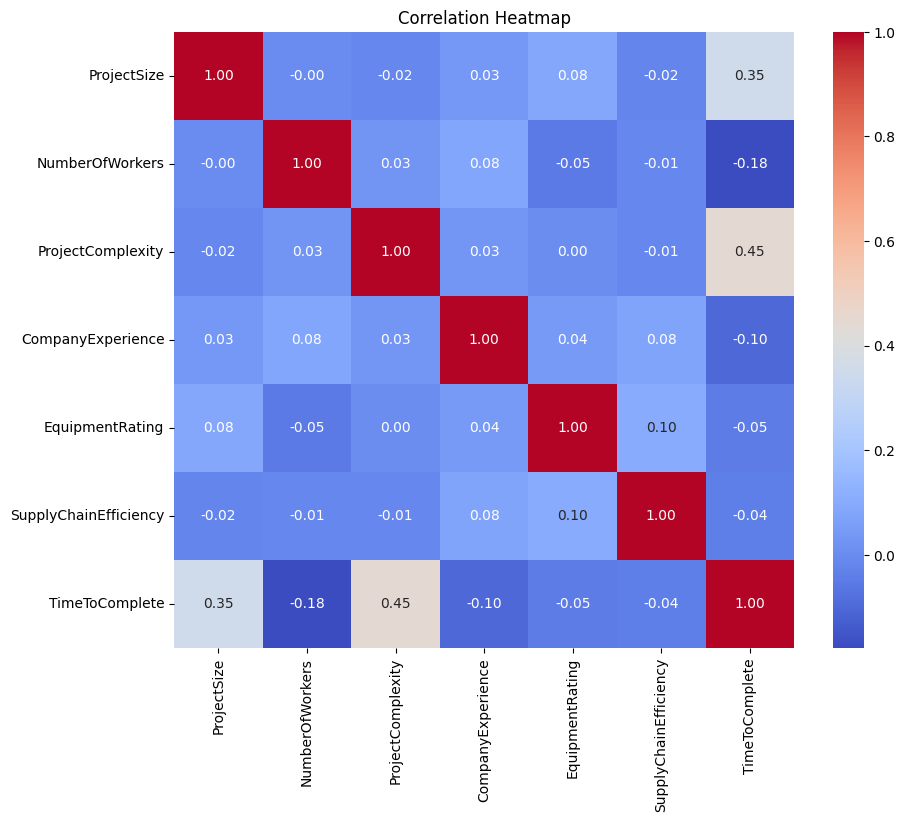

In [2]:
url = "https://richardson.byu.edu/220/construction.csv"
data = pd.read_csv(url)

print(data.info())
print(data.head())
print(data.describe())
print(data.isnull().sum())

for column in data.select_dtypes(include='number').columns:
    plt.figure()
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribution of {column}')

plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [3]:
# Model

X = data.drop('TimeToComplete', axis=1)
y = data['TimeToComplete']

categorical_features = ['ClimateCondition', 'FundingType']
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(), categorical_features)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', LinearRegression())])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 312.7318927438929
R-squared: 0.3588945583742684


In [4]:
# I tried to redifne the model but got same results

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

selector = SelectKBest(f_regression, k='all')

X_train_selected = selector.fit_transform(X_train_transformed, y_train)
X_test_selected = selector.transform(X_test_transformed)

model = LinearRegression()
model.fit(X_train_selected, y_train)

y_pred_selected = model.predict(X_test_selected)
new_mse = mean_squared_error(y_test, y_pred_selected)
new_r2 = r2_score(y_test, y_pred_selected)

print(f'New Mean Squared Error: {new_mse}')
print(f'New R-squared: {new_r2}')

New Mean Squared Error: 312.731892743893
New R-squared: 0.3588945583742682


In [5]:
#Instead of looking for the same k lets just use a for loop
best_k = 1
best_score = 0

for k in range(1, X_train_transformed.shape[1] + 1):
    selector = SelectKBest(f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train_transformed, y_train)
    X_test_selected = selector.transform(X_test_transformed)
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred_selected = model.predict(X_test_selected)
    score = r2_score(y_test, y_pred_selected)

    if score > best_score:
        best_k = k
        best_score = score

# Re run using best k
selector = SelectKBest(f_regression, k=best_k)
X_train_selected = selector.fit_transform(X_train_transformed, y_train)
X_test_selected = selector.transform(X_test_transformed)
model = LinearRegression()
model.fit(X_train_selected, y_train)
y_pred_selected = model.predict(X_test_selected)
optimal_mse = mean_squared_error(y_test, y_pred_selected)
optimal_r2 = r2_score(y_test, y_pred_selected)

print(f'Optimal k: {best_k}')
print(f'Optimal Mean Squared Error: {optimal_mse}')
print(f'Optimal R-squared: {optimal_r2}')

Optimal k: 9
Optimal Mean Squared Error: 301.39550460912136
Optimal R-squared: 0.38213433752763826


The initial model included all available predictors, which could have led to a model that was too complex for easy interpretation and potentially included irrelevant or less significant features.

The refined model is simpler and likely more interpretable, with fewer predictors making it easier to understand the relationship between each predictor and the target variable.

The refined model did not suffer a significant loss in accuracy, as evidenced by the improved metrics.

The simpler model is more practical for stakeholders. Construction estimators can focus on fewer, more impactful factors, which may facilitate better decision-making.

In [6]:
new_data_url = "https://richardson.byu.edu/220/construction_new.csv"
new_data = pd.read_csv(new_data_url)

In [7]:
new_data_transformed = preprocessor.transform(new_data)
new_data_selected = selector.transform(new_data_transformed)
new_predictions = model.predict(new_data_selected)


In [8]:
mse = mean_squared_error(y_train, model.predict(X_train_selected))

se = np.sqrt(mse)

df = len(y_train) - best_k - 1

t_value = stats.t.ppf(1-0.025, df)

confidence_intervals = [(pred - t_value * se, pred + t_value * se) for pred in new_predictions]

for i, (lower, upper) in enumerate(confidence_intervals):
    print(f"Prediction {i+1}: {new_predictions[i]} (95% CI: {lower} - {upper})")

Prediction 1: 172.39199705159075 (95% CI: 129.06279201849932 - 215.72120208468218)
